The following activities were originally designed for EARS33 at Dartmouth, and they have been modified for a classroom and workshop setting in a few places, including at Franklin and Marshall in a geomorphology class taught by Dorothy Merritts. 

# Introduction

The US Geologic Survey, the federal agency that maintains stream gages, is entering the 21st century by making it easier to find and retrieve their data. Most development so far has been in R, but a few blessed individuals have been developing a similar package in Python, [dataretrieval](https://github.com/USGS-python/dataretrieval)

# Learning objectives

- Practice data analysis skills with `pandas` and plotting skills with `matplotlib`
- Recognize [RESTful APIs](https://www.codecademy.com/article/what-is-rest) and formulaic, automated data retrieval from agencies like the USGS with `dataretrieval`
- Test concepts of watershed hydrology addressed in textbook and lecture with real-life data
- Devise algorithmic approaches to analyzing time series data

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
from dataretrieval import nwis
import pandas as pd
import numpy as np

# Part one: understanding stream gage data

I teach about nested watersheds in Surface Processes

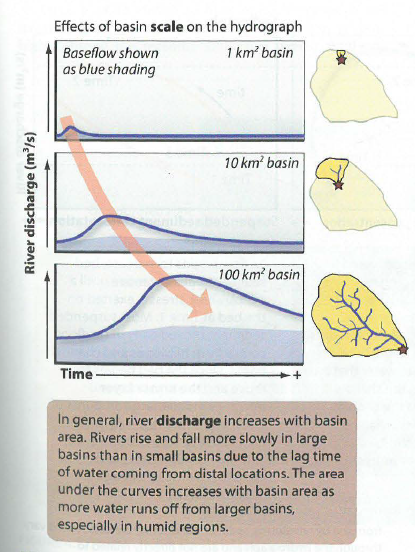

Let's use some real-life data to see if the real-world version looks anything like the idealized version! I have selected three nested watersheds in New Hampshire by their stream gage IDs (I looked at a map from the [USGS National Water Dashboard](https://dashboard.waterdata.usgs.gov/app/nwd/en/?region=lower48)).

## Retrieve and clean some site data

In [ ]:
# Make a list of strings corresponding to site IDs. 
# These use quotes to denote they are strings and not numbers
# They are separated by commas and bound by square brackets

sitelist = ["01075000", "01081500", "01092000"]

Let's look at the available data of our `sitelist` variable

In [ ]:
site_info = nwis.get_record(sites=sitelist, service='site')

print('Available data are:\n', site_info.columns.values) # "\n" just puts a line break in a text (string)
print('Station names are:\n', site_info['station_nm'])


## Mini-assignment 1

Using my data calls as an example, find the coordinates of these sites. You can find what these dizzying terms mean in this [hard-to-find example webpage from the USGS](https://waterservices.usgs.gov/nwis/site/?siteOutput=Expanded&site=01075000). For your own reference, plot them as locations in Google Maps or the mapping program of your choosing. 

In [ ]:
# Code here

Now, let's collect data on streamflow!

In [ ]:
# Initialize a blank dataframe object
df = pd.DataFrame()

In [ ]:
# This loop will iterate through each of the objects in sitelist and assign it 
# a number "i" as it assigns the variable siteNumber to the sitelist object

for i, siteNumber in enumerate(sitelist):
    # This is the parameter code for discharge in cfs
    parameterCode = "00060"
    # These are strings of dates
    startDate = "2023-01-01"
    endDate = "2023-12-31"
    # Make a temporary dataframe to store the records of each site
    df_temp = nwis.get_record(sites=siteNumber, service='dv', start=startDate, end=endDate, parameterCd='00060')
    # And then concatenate (stick on vertically) each site's data to the previous sites' data
    df = pd.concat([df, df_temp])
    # This method keeps our dataframe compact - each of the sites have the same
    # data, and we can always parse by site number later

Parameter codes for the USGS are here:https://help.waterdata.usgs.gov/codes-and-parameters/parameters
To get discharge, use `"00060"`



In [ ]:
df

Now we're going to do a `groupby` that will [group rows with similar values](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) for a certain column for analysis. After we `groupby`, we can query the values of a different column, but grouped by the first column. 

In this case the code is going to make three separate plots, one for each `site_no`, of the column `00060_Mean`, or mean daily discharge. 

In [ ]:
df.groupby(by='site_no')['00060_Mean'].plot()


You may notice that there are codes associated with each measurement in `00060_Mean_cd`. The The `P` values are provisional data. We can create a dataframe with only non-provisional data by [subsetting](https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html) the data:

In [ ]:
no_prov = df[df['00060_Mean_cd'] != 'P']
no_prov

The code selects rows from a pandas dataframe 'df' where the value in the column '00060_Mean_cd' is not equal to (`!=`)'P'. The resulting dataframe is then stored in the variable 'no_prov'. In simpler terms, the code filters out rows from the dataframe where the value in a particular column is 'P' and stores the remaining rows in a new dataframe called 'no_prov'.

^^^ I had ChatGPT write that summary! I asked it "translate this block of code into a simple English explanation". Fun. 

## Comparing some hydrographs

Whew. Now let's plot.

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))

for site, group in df.groupby(by='site_no'):
    
    # site_info = nwis.get_record(sites=site, service='site')

    group.plot(y='00060_Mean', ax=ax, legend=True, label=site)

ax.set_xlabel('Date')
ax.set_ylabel('Streamflow (cfs)')

#https://stackoverflow.com/questions/39902522/pandas-groupby-object-in-legend-on-plot

## Mini-assignment 2: Tell me a story with data!

Now it's your turn. Use the [National Water Dashboard](https://dashboard.waterdata.usgs.gov/app/nwd/?region=lower48&aoi=default) to pick a stream gage and tell me a story!
- Select a specific site or series of sites like in the example above
- Change the start and end date to bracket an interesting time
- If you have time and want to, are there data other than streamflow you'd like to plot as a time series?

In [ ]:
# Do sick coding here

Share your hydrograph with your neighbor.

# Part two: Flood recurrence 

Site 01081500 has been gaged since 1903, but there's a data gap in the 80s. Let's go with 01092000, gaged since the 40s. 

In [ ]:
# Let's call this new dataframe "df_hist" for historical data, 
# so we don't get confused 

df_hist = nwis.get_record(sites='01092000', service='dv', start='1900-01-01', end=endDate, parameterCd='00060')

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
data = df_hist.plot(y='00060_Mean', ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Streamflow (cfs)')

What do these data look like?

In [ ]:
df_hist.head()


Cool! Each entry in `datetime` is a date of a year with the maximum streamflow. Now if we're interested in recurrence intervals, we're gonna have to manipulate this dataset a little. I'll get you started creating a ranking for these flows, and then you'll be in charge of calculating recurrence intervals

Note: I know this isn't water year. I'll fix this at some point. 

In [ ]:
#pandas datetimeindex docs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html
df_hist['year'] = pd.DatetimeIndex(pd.to_datetime(df_hist.index)).year

# This is a slightly weird thing, where the datetime is stored as an "index"
# of the dataframe rather than a column, so I first turned the index into 
# a datetime object with the pd.to_datetime(df_hist.index) call, 
# and then parsed that datetime object for the year

df_hist.head() 

In [ ]:
# Here I'm going to ask "What is the maximum value for each year?" the groupby()
# function puts all the things that have the same value in a specified column
# and then finds the max value, in this case 
# Read more here: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html

annual_max_floods = df_hist.groupby('year').max().reset_index()

# The groupby() function creates this new mini-dataframe, "annual_max_floods",
# which can be manipulated just like our original dataframe, df_hist


# the reset_index() call is just a little nuance where I don't want it to turn
# my year groups into the index of the dataframe, or else Pandas will thing
# I want to plot variables as a timeline, which I don't want to do 

annual_max_floods

Cool, so you know "N" now, let's find r

In [ ]:
# Here I'm asking Pandas to rank the discharge column in descending order...

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rank.html
annual_max_floods['rank'] = annual_max_floods['00060_Mean'].rank(ascending=False)

# ...and then show them to me sorted!

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
annual_max_floods.sort_values(by=['rank'])

Now you have N and r, which is all you need. Let's take a look at the data....

In [ ]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.scatter.html
annual_max_floods.plot.scatter(x='rank',y='00060_Mean')

# Why don't you edit the above code to:
# Properly label x and y axes
# maybe...add the year as a color for the data points?

Now let's find flood recurrence interval: Recurrence Interval equals the number of years, plus one, divided by the magnitude rank for which you wish to calculate the recurrence interval.

Recurrence Interval = (Years + 1) / Rank

More here: https://www.usgs.gov/special-topics/water-science-school/science/floods-and-recurrence-intervals

In [ ]:
# Don't forget, you can treat a column name like a variable and do math on the whole column
# Here's an example where we convert the cfs to cubic meters per second

annual_max_floods['Discharge_m3_s-1'] = annual_max_floods['00060_Mean'] / 35.315
annual_max_floods.head()

## Mini assignment 3

Create a figure where (1) recurrence interval is plotted (on a log scale) on the x axis, (2) peak discharge is plotted on the Y axis, and (3) the points are colored by the year of the flood.

In [ ]:
# Your plot here

In [ ]:
# If you need a hint for how to make a log scale, 
# I'll show you an example with the discharge data:
fig, ax = plt.subplots(figsize=(15,4))
data = df_hist.plot(y='00060_Mean', ax=ax)
ax.set_yscale('log')

(Yes, ugly but now you know the syntax!)

# Hypothesis testing with your code!

One of the things I wonder in my work in the Arctic is based on climate change, will the biggest discharge events (which have historically occurred early in the growing season and are associated with snowmelt) instead be associated with rainstorms later in the growing season, when the ground is more thawed?.

So I used this search page to create a table of all Alaska gage sites and then use Pandas to parse the resulting table: https://waterdata.usgs.gov/ak/nwis/current?submitted_form=introduction

The following code was originally (and hastily) developed for a [computational workshop](https://github.com/jmdelvecchio/computational-arctic-workshop), so it may not be as polished as code above. As always I welcome your questions, feedback, and improvement!

In [ ]:
import requests


url = 'https://waterdata.usgs.gov/ak/nwis/current?index_pmcode_STATION_NM=1&index_pmcode_DATETIME=2&group_key=basin_cd&format=sitefile_output&sitefile_output_format=html_table&column_name=agency_cd&column_name=site_no&column_name=station_nm&sort_key_2=site_no&html_table_group_key=NONE&rdb_compression=file&list_of_search_criteria=realtime_parameter_selection'

usgs_url = requests.get(url)



`pd.read_html()` parses for tables, which is why I generated a table (and not the tab-delimeted text, which seems like that should have worked but whatever)

In [ ]:
# This returns a LIST of dataframes
from io import StringIO

usgs_data = pd.read_html(StringIO(usgs_url.text))

In [ ]:
# So let's look at the first (and only) dataframe that comes out
usgs_data = usgs_data[0]

usgs_data.head()

In [ ]:
# get_record takes a string
site_string = str(usgs_data.iloc[0]["Site Number"])
# And iloc[0] is "the data at index location 0"
site_info = nwis.get_record(sites=site_string, service='site')
print("Lat: ", site_info['dec_lat_va'])
print("Long: ", site_info['dec_long_va'])

In [ ]:
# Get the discharge history for the site and clean bad data
df_hist = nwis.get_record(sites=site_string, service='dv', start='1900-01-01', end=endDate, parameterCd='00060')

# Or should you filter by provisional data? Your call 
df_hist.replace(-999999.0, np.nan, inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
data = df_hist.plot(y='00060_Mean', ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Streamflow (cfs)')

In [ ]:
#pandas datetimeindex docs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html
df_hist['year'] = pd.DatetimeIndex(pd.to_datetime(df_hist.index)).year

# This is a slightly weird thing, where the datetime is stored as an "index"
# of the dataframe rather than a column, so I first turned the index into 
# a datetime object with the pd.to_datetime(df_hist.index) call, 
# and then parsed that datetime object for the year

df_hist.head() 

In [ ]:
# Here I'm going to ask "What is the maximum value for each year?" the groupby()
# function puts all the things that have the same value in a specified column
# and then finds the max value, in this case 
# Read more here: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html

annual_max_floods = df_hist.groupby('year').max().reset_index()

# The groupby() function creates this new mini-dataframe, "annual_max_floods",
# which can be manipulated just like our original dataframe, df_hist


# the reset_index() call is just a little nuance where I don't want it to turn
# my year groups into the index of the dataframe, or else Pandas will thing
# I want to plot variables as a timeline, which I don't want to do 

annual_max_floods

In [ ]:
# Here I'm asking Pandas to rank the discharge column in descending order...

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rank.html
annual_max_floods['rank'] = annual_max_floods['00060_Mean'].rank(ascending=False)

# ...and then show them to me sorted!

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
annual_max_floods.sort_values(by=['rank'])

In [ ]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.scatter.html
annual_max_floods.plot.scatter(x='rank',y='00060_Mean')

# Why don't you edit the above code to:
# Properly label x and y axes
# maybe...add the year as a color for the data points?

Maybe this is the time to write a function that does all that work for you "under the hood" rather than in big code blocks because you'll want to do the same thing to the data over and over again

In [ ]:
def get_annual_floods(site_string):
  # site_string is the string of the gage
  site_info = nwis.get_record(sites=site_string, service='site')
  
  df_hist = nwis.get_record(sites=site_string, service='dv', start='1900-01-01', end=endDate, parameterCd='00060')
  df_hist.replace(-999999.0, np.nan, inplace=True)

  df_hist['year'] = pd.DatetimeIndex(pd.to_datetime(df_hist.index)).year

  annual_max_floods = df_hist.groupby('year').max().reset_index()

  annual_max_floods['rank'] = annual_max_floods['00060_Mean'].rank(ascending=False)

  # And then this is the output to your function: a sorted dataframe
  return annual_max_floods.sort_values(by=['rank'])

Can you add some lines to the function that perhaps print the name of the site when you call `get_annual_floods()`?



In [ ]:
# usgs_data.iloc[0] is pulling the first row of the dataframe (iloc is short for "index location")
# Don't forget that Python starts with 0 :)

max_flood_data = get_annual_floods(str(usgs_data.iloc[0]["Site Number"]))

max_flood_data.plot.scatter(x='rank',y='00060_Mean', c='year', cmap='viridis')

In [ ]:
# Now we do the next index location
max_flood_data = get_annual_floods(str(usgs_data.iloc[1]["Site Number"]))

max_flood_data.plot.scatter(x='rank',y='00060_Mean', c='year', cmap='viridis')

In [ ]:
max_flood_data = get_annual_floods(str(usgs_data.iloc[2]["Site Number"]))
max_flood_data.plot.scatter(x='rank',y='00060_Mean', c='year', cmap='viridis')

# Deliverable: let's `h4ck`

So here is my prompt: can you test the hypothesis that <b>maximum floods are occurring later in the year? And are those floods getting bigger?</b>

Ingredients:
- Sitewise parsing of maximum flood dates
- Some means of quantifying the trend in date of the peak flood (perhaps a regression line fit to the day of year of max flood?)
- Some means of reducing that quantification of trend down to a single number or variable that can be added to the `usgs_data` dataframe

A note: you might find yourself wanting to <i>iterate</i> through numbers or a list of sites to do the above work, in which case you'll have to learn a little about []`for` loops](https://wiki.python.org/moin/ForLoop) and, if you <i>really</i> want to get tricky, maybe some [list comprehension](https://docs.python.org/3/tutorial/datastructures.html)

This is a somewhat challenging task for such an early topic in the class. Work together, search the `pandas` docs and/or StackExchange, and ask Joanmarie for advice. <i>But no ChatGPT!</i>

Deliverables:
1. This notebook completed, including the mini-assignments, run without any errors
2. Some alteration of the `get_annual_floods()` function so that the axes are labeled nicely and that the site names get attached to the plots (maybe as plot titles?)
3. At least one plot or dataframe printed addressing the hypothesis about the timing of floods, and at least one plot or dataframe printed addressing the magnitude of those floods. 
4. A few sentences in a Markdown cell at the end using your own words to accept or reject the hypotheses. 